# Macro Attention Index (MAI) Data

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from FOMCDataPreprocess import FOMCPreprocess

## Daily Data

In [3]:
def get_daily_data() -> pd.DataFrame: 
    
    path   = os.path.join(FOMCPreprocess().processed_data, "DailyMAI.parquet")
    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow"))
    
    return df_out

df_daily = get_daily_data()

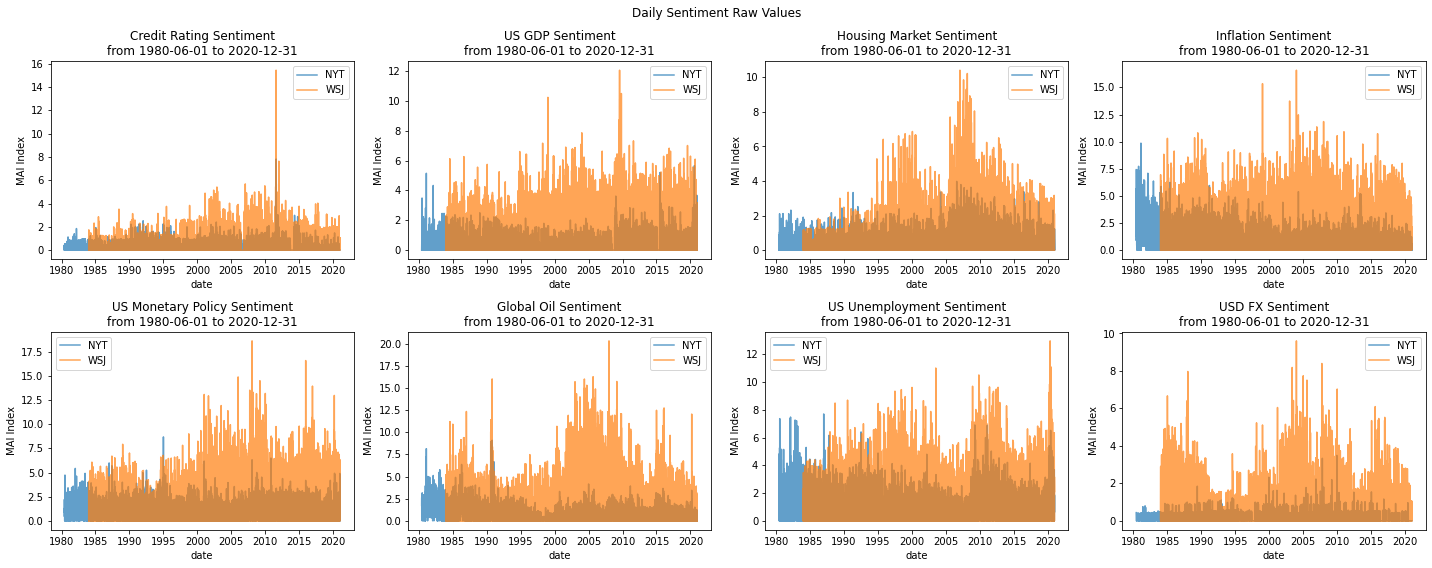

In [4]:
def plot_sentiment_data(df_daily: pd.DataFrame, title: str) -> plt.Figure: 
    
    sentiment_types = df_daily.sentiment_type.drop_duplicates().sort_values().to_list()
    fig, axes       = plt.subplots(ncols = len(sentiment_types) // 2, nrows = len(sentiment_types) // 4, figsize = (20,8))

    col_renamer     = {
        "ni": "NYT",
        "wi": "WSJ"}

    sentiment_renamer = {
        "credit_rating": "Credit Rating",
        "gdp"          : "US GDP",
        "house_mkt"    : "Housing Market",
        "inflation"    : "Inflation",
        "monetary"     : "US Monetary Policy",
        "oil"          : "Global Oil",
        "unemp"        : "US Unemployment",
        "usd"          : "USD FX"}



    for sentiment_type, ax in zip(sentiment_types, axes.flatten()):

        df_plot = (df_daily.query(
            "sentiment_type == @sentiment_type")
            [["date", "sentiment_source", "value"]].
            rename(columns = {"sentiment_source": ""}).
            pivot(index = "date", columns = "", values = "value").
            rename(columns = col_renamer))

        (df_plot.plot(
            ax     = ax,
            alpha  = 0.7,
            ylabel = "MAI Index",
            title  = "{} Sentiment\nfrom {} to {}".format(
                sentiment_renamer[sentiment_type],
                df_plot.index.min(),
                df_plot.index.max())))

    fig.suptitle(title)
    plt.tight_layout()
    
plot_sentiment_data(df_daily, "Daily Sentiment Raw Values")

In [5]:
def _get_zscore(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean  = lambda x: x.value.ewm(span = window, adjust = False).mean(),
            roll_std   = lambda x: x.value.ewm(span = window, adjust = False).std(),
            z_score    = lambda x: (x.value - x.roll_mean) / x.roll_std,
            lag_zscore = lambda x: x.z_score.shift()).
        dropna())
    
    return df_out

def get_zscore(df_daily: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_zscore = (df_daily.groupby(
        "variable").
        apply(_get_zscore, window).
        reset_index(drop = True).
        rename(columns = {"value": "raw_value"}))
    
    return df_zscore

df_zscore = get_zscore(df_daily)

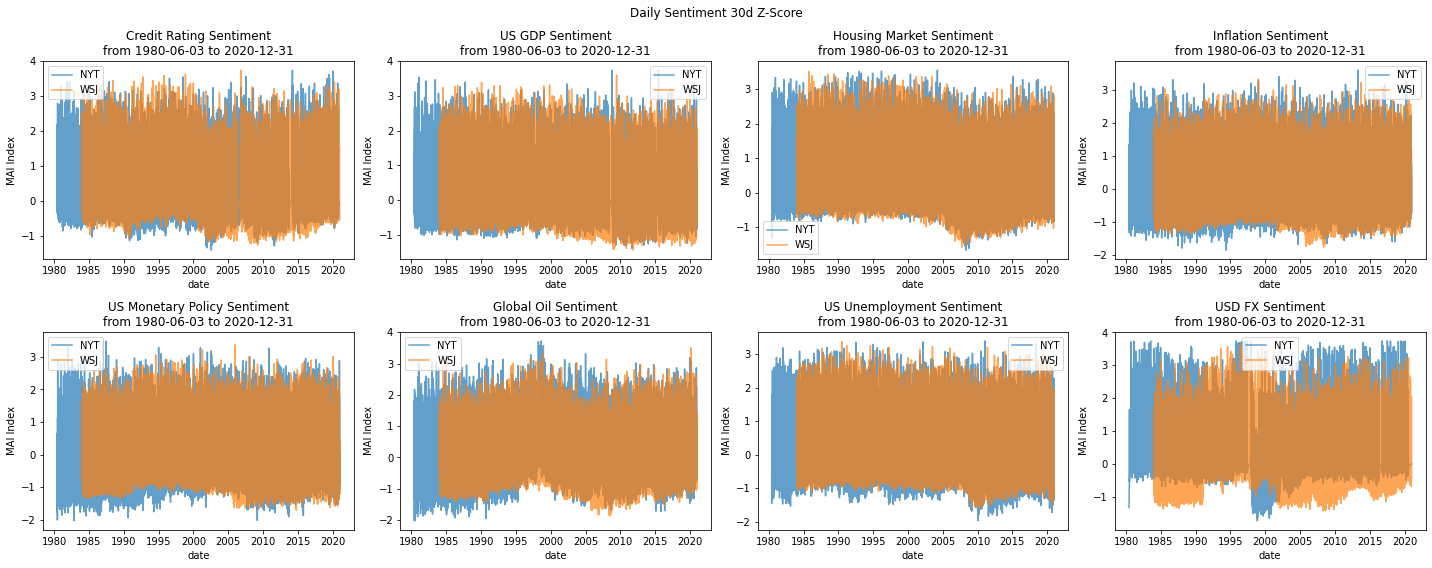

In [6]:
plot_sentiment_data(
    df_daily = df_zscore.rename(columns = {"lag_zscore": "value"}),
    title    = "Daily Sentiment 30d Z-Score")

In [7]:
def _get_mean(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean  = lambda x: x.value.ewm(span = window, adjust = False).mean()).
        dropna())
    
    return df_out

def get_mean(df_daily: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_zscore = (df_daily.groupby(
        "variable").
        apply(_get_mean, window).
        reset_index(drop = True).
        rename(columns = {"value": "raw_value"}))
    
    return df_zscore

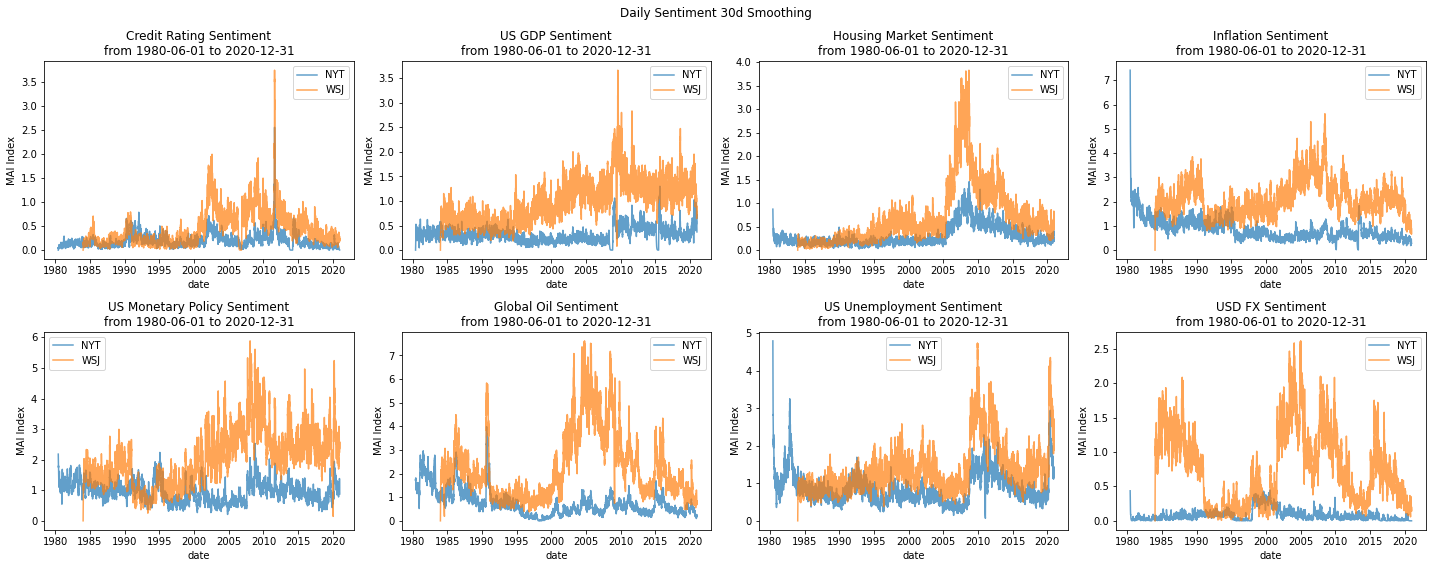

In [8]:
plot_sentiment_data(
    df_daily = get_mean(df_daily, 30).rename(columns = {"roll_mean": "value"}),
    title    = "Daily Sentiment 30d Smoothing")

# Monthly

In [9]:
def get_daily_data() -> pd.DataFrame: 
    
    path   = os.path.join(FOMCPreprocess().processed_data, "MonthlyMAI.parquet")
    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow"))
    
    return df_out

df_monthly = get_daily_data()

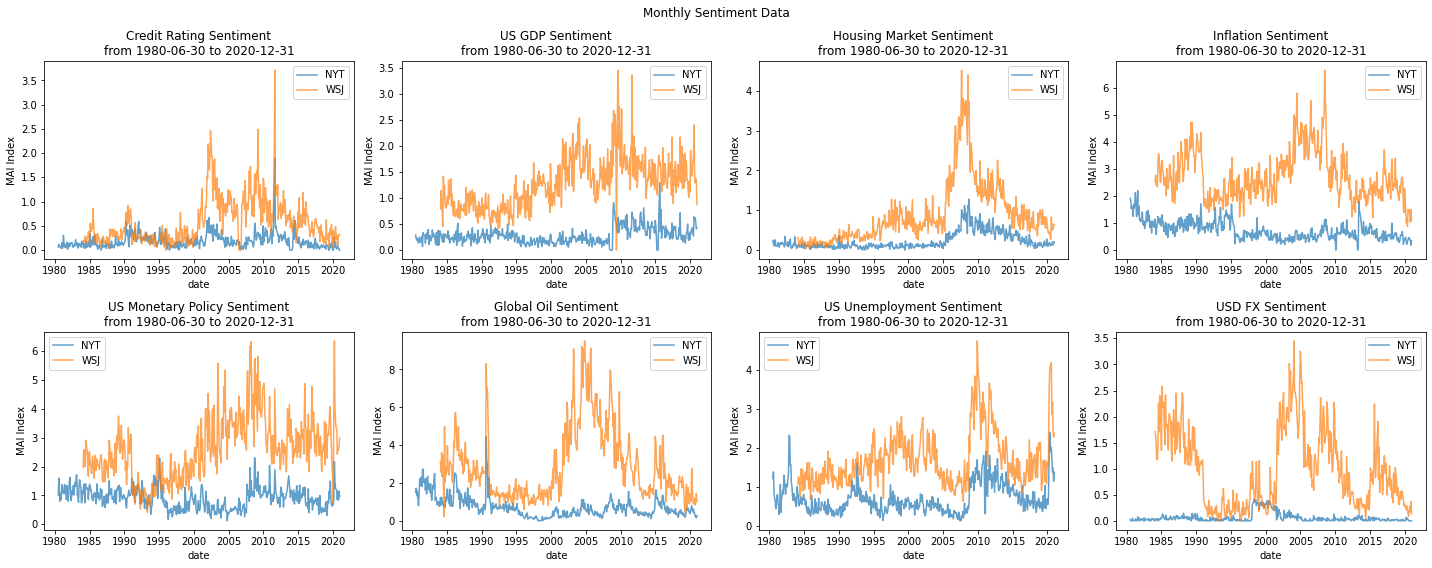

In [10]:
plot_sentiment_data(df_monthly, title = "Monthly Sentiment Data")